## Notes
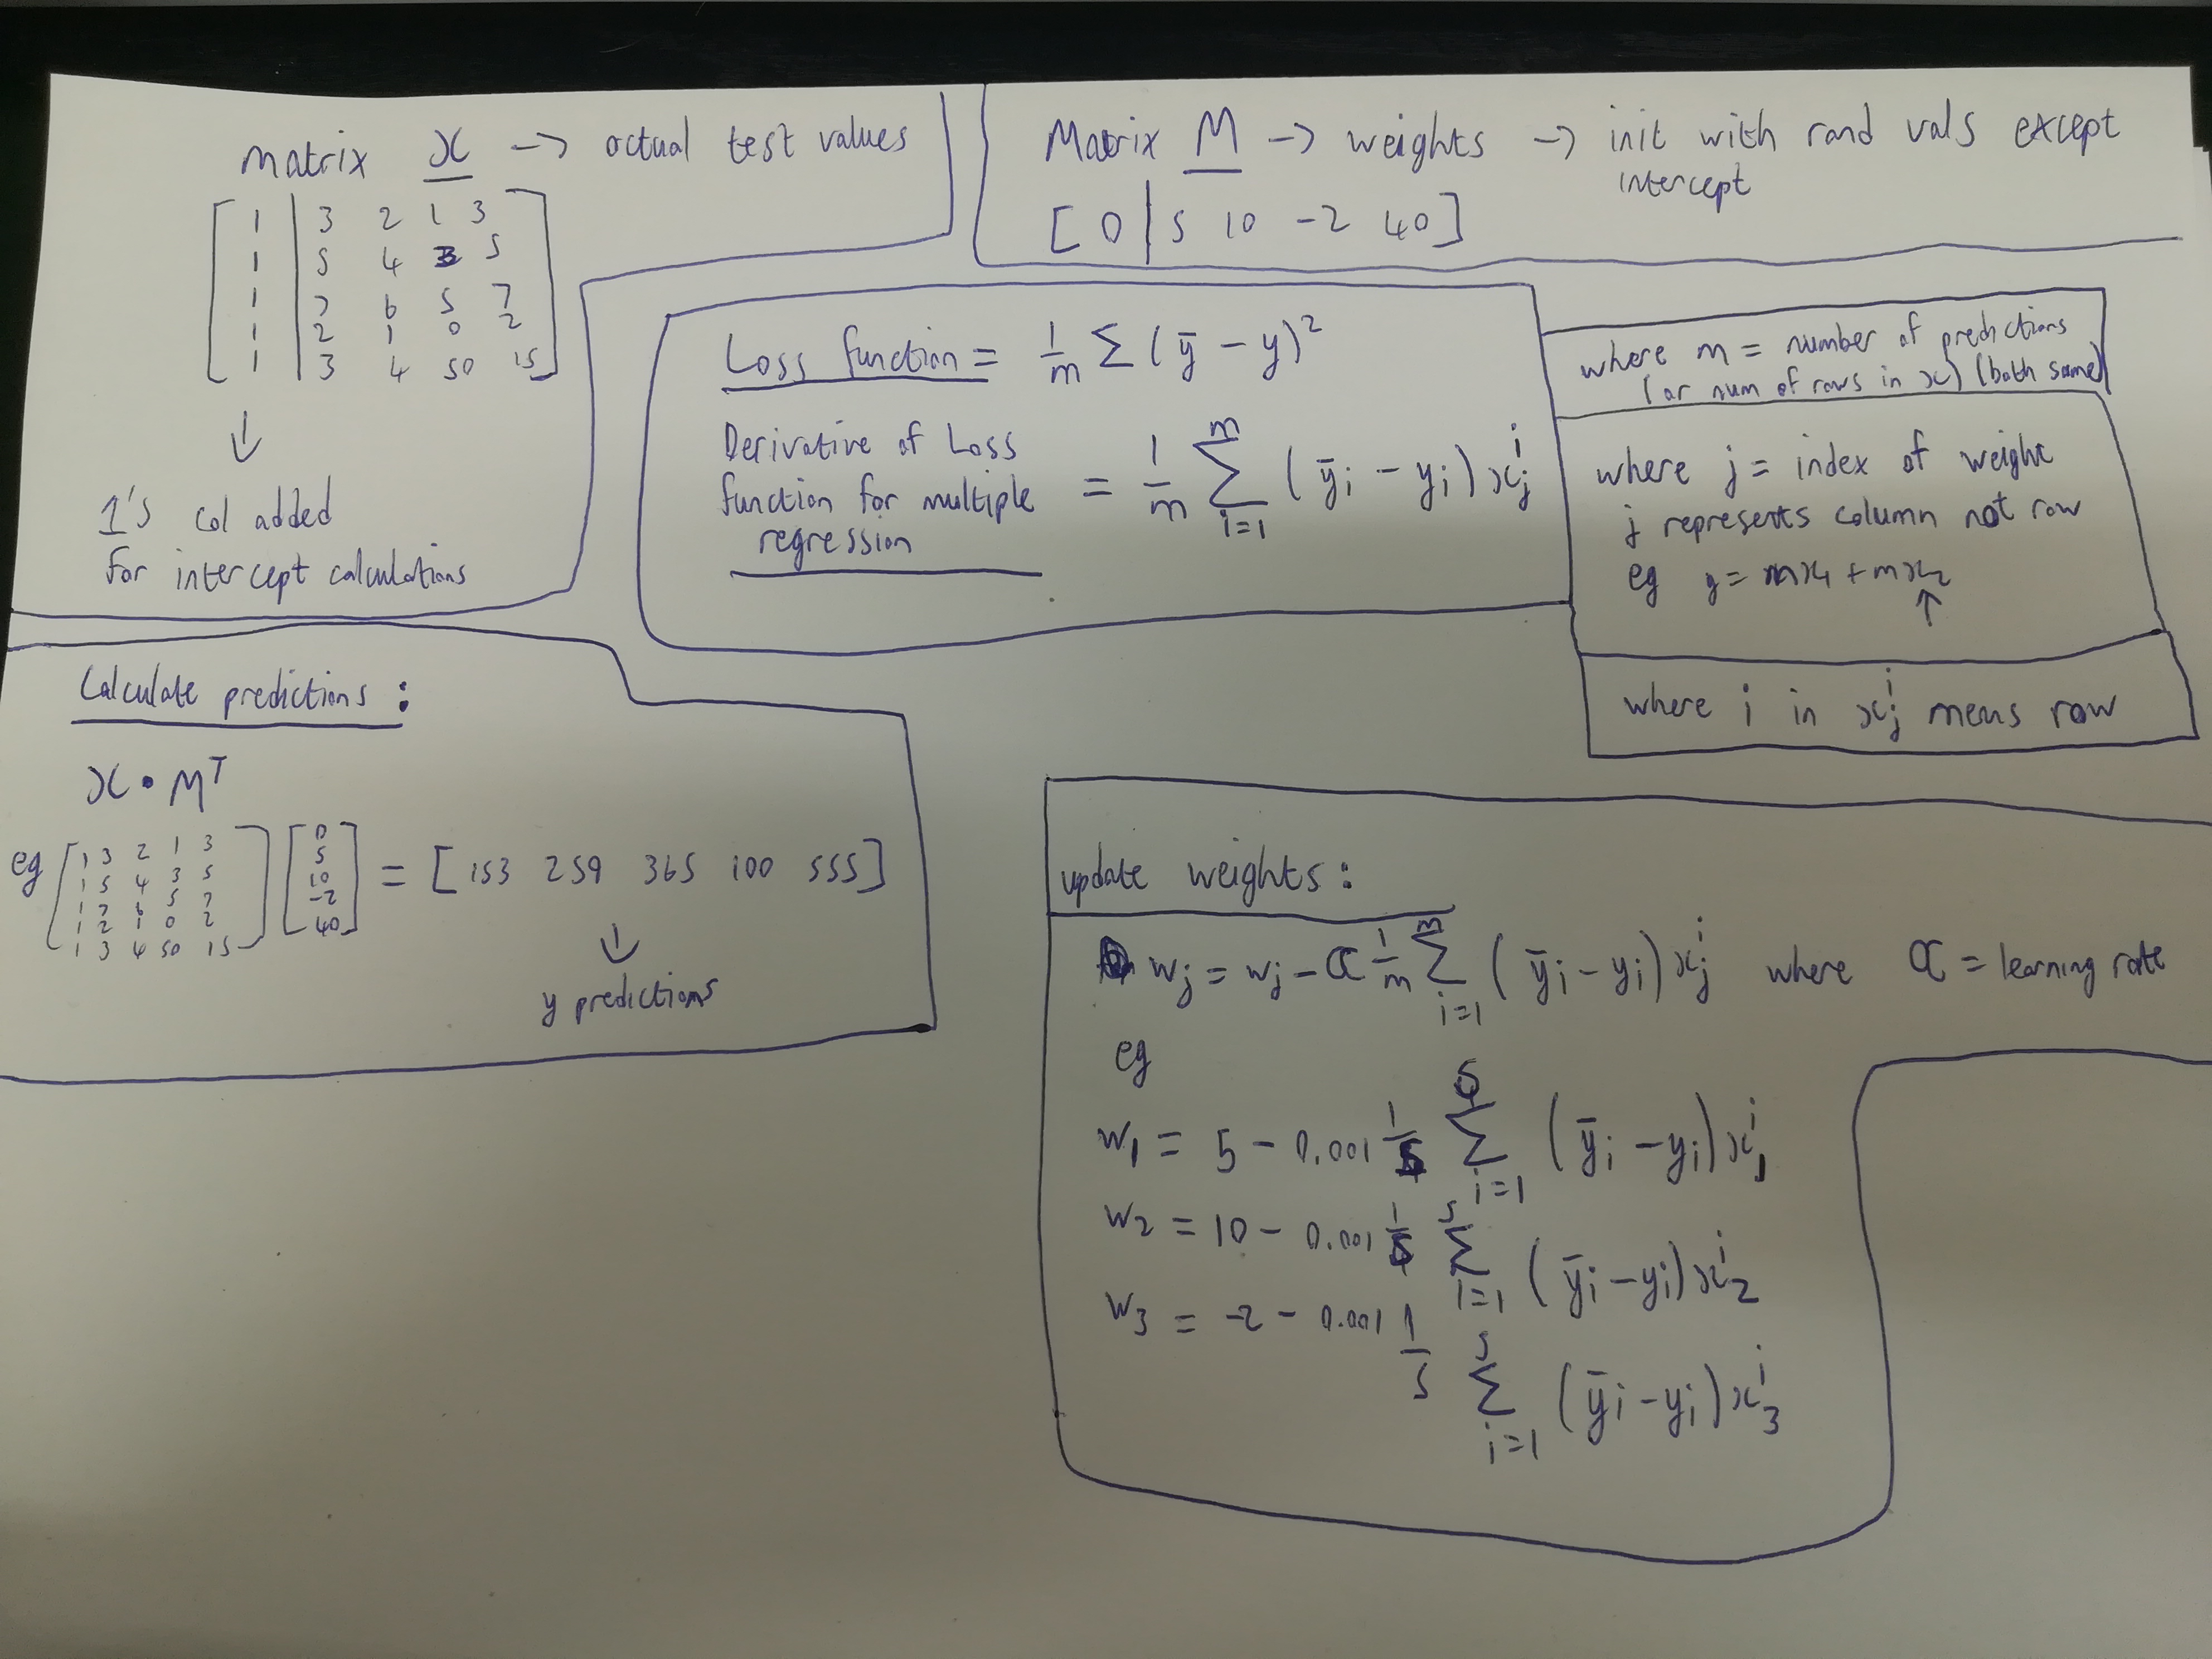

## Linear regression

In [1]:
using DataFrames
using Plots
using CSV
using Statistics
using StatsBase
using StatsPlots

In [2]:
# read data

df=CSV.read("./real_estate.csv",DataFrame)
first(df,3)

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station
,Int64,Float64,Float64,Float64
1,1,2012.92,32.0,84.8788
2,2,2012.92,19.5,306.595
3,3,2013.58,13.3,561.985


In [3]:
# describe data

describe(df)

,variable,mean,min,median,max,nmissing
,Symbol,Float64,Real,Float64,Real,Int64
1,No,207.5,1,207.5,414,0
2,X1 transaction date,2013.15,2012.67,2013.17,2013.58,0
3,X2 house age,17.7126,0.0,16.1,43.8,0
4,X3 distance to the nearest MRT station,1083.89,23.3828,492.231,6488.02,0
5,X4 number of convenience stores,4.0942,0,4.0,10,0
6,X5 latitude,24.969,24.9321,24.9711,25.0146,0
7,X6 longitude,121.533,121.474,121.539,121.566,0
8,Y house price of unit area,37.9802,7.6,38.45,117.5,0


In [4]:
function replaceCols(colNames::Vector{String})
    newCols=String127[]
    for n in colNames
        push!(newCols,String(replace(strip(n)," "=>"_")))
    end
    rename!(df,newCols)
end

replaceCols (generic function with 1 method)

In [5]:
# replace col names

replaceCols(names(df))
names(df)

8-element Vector{String}:
 "No"
 "X1_transaction_date"
 "X2_house_age"
 "X3_distance_to_the_nearest_MRT_station"
 "X4_number_of_convenience_stores"
 "X5_latitude"
 "X6_longitude"
 "Y_house_price_of_unit_area"

In [6]:
# drop No col

select!(df, Not(:No))
size(df)

(414, 7)

In [8]:
# tdf=df[1:300, :]

In [10]:
# separate into test and training data

test_df=df[301:size(df)[1], :]
train_df=df[1:300, :]

# separate prices from training data

actual_y=select(train_df,:Y_house_price_of_unit_area)
train_x=select(train_df,Not([:Y_house_price_of_unit_area]))

println(size(actual_y))
println(size(train_x))

(300, 1)
(300, 6)


In [11]:
# normalization function

function normalize!(df_to_normalize::DataFrame)
    
    colNames=names(df_to_normalize)
    
    for cName in colNames  # loops through each column
        vals=df_to_normalize[:,cName] # make vector copy of values in column
        std_dev=std(vals) # calculate standard deviation
        mean_val=mean(vals) # calculate mean
        
        #=
        use broadcast operator . to apply mathematical function to each element
        in the column
        
        The function applied is: (x - mean) / std
        
        The dataframe to update then has its column updated with the 
        new values
        =#
        df_to_normalize[!, cName] = ((vals .- mean_val) ./ std_dev) 
    end
    
end

normalize! (generic function with 1 method)

In [12]:
# normalize training data

normalize!(actual_y)
normalize!(train_x)


In [13]:
# check to see if norm applied
first(train_x,3)

,X1_transaction_date,X2_house_age,X3_distance_to_the_nearest_MRT_station,X4_number_of_convenience_stores
,Float64,Float64,Float64,Float64
1,-0.846294,1.25009,-0.784632,2.00992
2,-0.846294,0.145327,-0.611337,1.66771
3,1.53277,-0.402633,-0.411723,0.298865


In [14]:
# unnecessary part of a tutorial. Kept for future reference

# plot data
# Plots.scatter(df.X4_number_of_convenience_stores, df.Y_house_price_of_unit_area, xlabel="num of conv stores", ylabel="house price")

## Hypothesis

There are 6 features, therefore, the hypothesis will be:

####   hθ(x) = θ0 + θ1x1 + θ2x2 + θ2x3 + θ2x4 + θ2x5 + θ2x6 


or more simply:
####   y = m1x + m2x + m3x + m4x + m5x + m6x + b

In [15]:
# Y prediction function

#=
    X_Matrix contains all the feature values
    M_Matrix contains all the weight and intercept values

    multiplies the x matrix with the transpose of the m matrix
    returns a matrix consisting of a single row with the predicted y values
=#

function predict_y(X_Matrix::Matrix, M_Matrix::Matrix)::Matrix
    return Matrix((X_Matrix * M_Matrix')') # return transpose because fucking julia stores mult results in cols
end

predict_y (generic function with 1 method)

##  Cost/Loss function

equation is:
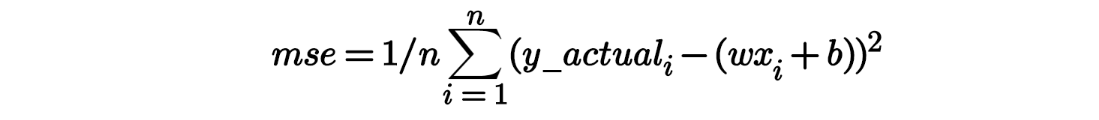

derivative for multiple features:
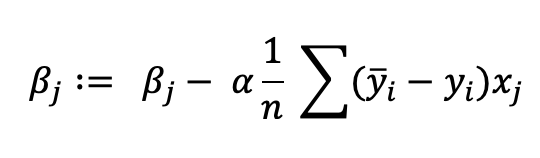




In [16]:
#=
    calculates loss with respect to a given weight 

    params:
    -------

    x: Matrix:  
        test values past in for training
    y_pred: Matrix:
        predictions made using using current weights and x values
    y_actual: Matrix:
        actual y values provided with data

    returns: Float64
    --------
=#

function loss(x::Matrix, y_pred::Matrix, y_actual::Matrix, j::Int)::Float64
    
    m = size(x)[1]  # get num of rows   
    
    lSum=0
        
    for i in 1:m 
       lSum += ((y_pred[1, i] - y_actual[1, i]) * x[i, j])
    end
    
    return (1/m) * lSum
end
    

loss (generic function with 1 method)

In [17]:
#=
    calculates and updates weights 

    params:
    -------

    current_weights: Matrix:
        current weights
    x: Matrix:  
        test values past in for training
    learning_rate: Float64
        learning rate set by user
    y_pred: Matrix:
        predictions made using using current weights and x values
    y_actual: Matrix:
        actual y values provided with data

    returns: Matrix
    --------
=#

function updateWeights(current_weights::Matrix, learning_rate::Float64, x::Matrix, y_pred::Matrix, y_actual::Matrix)::Matrix{Float64}
    
    m = size(current_weights)[1]  # get num of rows   
    
    for j in 1:m 
        current_weights[1, j] = current_weights[1, j] - (learning_rate * loss(x, y_pred, y_actual, j))
    end
    
    return current_weights
    
end

updateWeights (generic function with 1 method)

In [18]:
#=
    trains linear regression model using gradient decent 

    params:
    -------

    x: Matrix:  
        test values past in for training
    y_actual: Matrix:
        actual y values provided with data
    learning_rate: Float64
        learning rate set by user
    epochs: Int
        the number of iterations to train for

    returns: Vector{Float64}
    --------
=#

function fit_linear_regression(x::Matrix, y_actual::Matrix, learning_rate::Float64, epochs::Int)::Vector{Float64}
    
    # concat a column of ones to x matrix that will represent y intercept
    x = hcat(ones(size(x)[1], 1), x)
    
    # create weights with random values
    weights = rand(1, size(x)[2])
    
    for i in 1:epochs
        
        # predict y values with current weights
        y_preds = predict_y(x, weights)
        
        # update weights
        weights = updateWeights(weights, learning_rate, x, y_preds, y_actual)
        
    end
    
    # return weights as vector
    return weights[1, :]
end

fit_linear_regression (generic function with 1 method)

##  Test model



In [19]:
# actual_y is converted to a matrix then transposed to make it match with y_preds
actual_y = Matrix(actual_y)
size(actual_y)

(300, 1)

In [57]:
# train model
param_vals=fit_linear_regression(Matrix(train_x), Matrix(actual_y'), 0.00001, 200000)

7-element Vector{Float64}:
 0.10346069991379644
 0.9666439247572779
 0.10308879983776553
 0.04833880934355417
 0.711494381446646
 0.39532303329473706
 0.1452455377689228

In [58]:
copy_of_param_vals=param_vals

7-element Vector{Float64}:
 0.10346069991379644
 0.9666439247572779
 0.10308879983776553
 0.04833880934355417
 0.711494381446646
 0.39532303329473706
 0.1452455377689228

## Compare accuracy

In [59]:
# test_df.X6_longitude
# test_df.Y_house_price_of_unit_area

In [60]:
param_vals[1]+(param_vals[2]*2013)+(param_vals[3]*2.5)+(param_vals[4]*156.244)+(param_vals[5]*4)+(param_vals[6]*24.96696)+(param_vals[7]*121.53992)

1984.1371750889093

In [111]:
function tes(m::Matrix{Float64})::Matrix{Float64}
    m[1,2]=22
    return m
end

tes (generic function with 1 method)

In [112]:
m=ones(1,3)

1×3 Matrix{Float64}:
 1.0  1.0  1.0

In [115]:
vec=m[1,:]


3-element Vector{Float64}:
  1.0
 22.0
  1.0

In [42]:
rand(1,3)

1×3 Matrix{Float64}:
 0.823583  0.286511  0.453846

In [32]:
xmat=Matrix(train_x)
size(xmat)[1]

414

In [37]:
xmat[2, 1]

-0.8226878210261311

In [40]:
xmat
hcat(ones(size(xmat)[1], 1), xmat)

414×7 Matrix{Float64}:
 1.0  -0.822688   1.25411    -0.791537   2.00498    1.12407    0.44822
 1.0  -0.822688   0.156896   -0.615866   1.66549    0.911342   0.400654
 1.0   1.53929   -0.387322   -0.413515   0.307513   1.48506    0.687352
 1.0   1.24493   -0.387322   -0.413515   0.307513   1.48506    0.687352
 1.0  -1.12059   -1.11587    -0.549332   0.307513   0.83318    0.59222
 1.0  -1.70932   -0.93154     0.86454   -0.371475  -0.481868  -1.35667
 1.0  -1.70932    1.47355    -0.364796   0.9865     0.829957   0.199314
 1.0   0.950568   0.227118   -0.630914   0.647006   0.917788   0.581143
 1.0   1.24493    1.22778     3.50853   -1.05046   -1.45687   -3.1785
 1.0   0.950568   0.0164529   0.554068  -0.371475  -0.138602  -1.2055
 1.0  -0.233967   1.49989    -0.537728  -1.05046    0.359376   0.0233862
 1.0   0.652661  -1.00176    -0.787118   1.66549    0.427062   0.634573
 1.0  -0.822688  -0.413655   -0.468782   0.307513  -0.312652   0.261215
 ⋮                                             